# Loads the processed h5 file and plots data
### the minimalist way (using analysis.py)

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *

In [13]:
# input parameters
run = '0083_droplets_10um_20mm'

# constants
detector_distance = 0.12
energy = 9.5

# analysis parameters
iq_thr = 0.2 # photon/pix
q_min, q_max = 20,30

### load  and analyse data

In [15]:
# load data
img,Iq,r,nshots,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

# convert q_scale
q = q_scale(r,detector_distance=detector_distance)

# convert intensity to photon/pix
img/=energy
Iq /=energy
i0 /=energy

# normalise to i0
Iq_norm = np.zeros(Iq.shape)
i0_avg = np.average(i0)
norm = i0/i0_avg
for i in range(int(nshots)):
    Iq_norm[i]=Iq[i]/norm[i]
    
# find hits
metric,hits = find_hits(Iq_norm,threshold=iq_thr)
hit_rate = np.sum(hits)/nshots
print('found %d hits with >%.1f photon/pix' % (hits.sum(), iq_thr))

# pump probe signal
hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on)

run0083_droplets_10um_20mm: 18000 shots
found 317 hits with >0.2 photon/pix


### plot

<IPython.core.display.Javascript object>


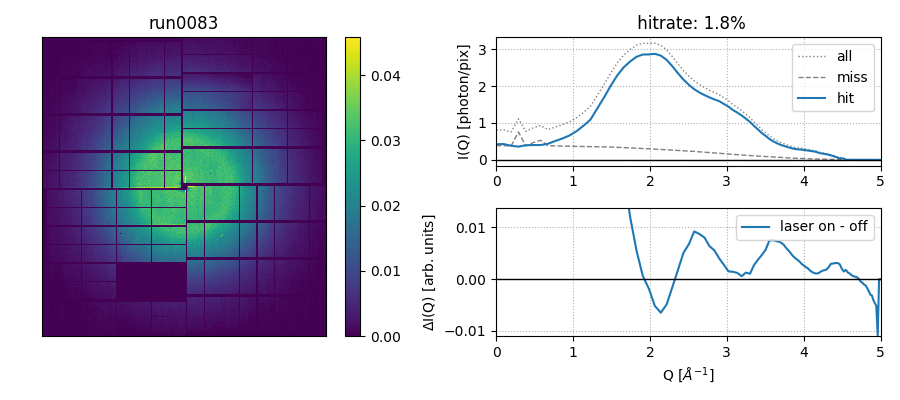

In [28]:
plt.figure(figsize=[9,4])

# 2d image
plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
#plt.imshow(img/nshots,clim=[0,0.2],origin='lower')
i = (img/nshots)
plt.imshow(i,clim=[0,i.mean()+2*i.std()],origin='lower')
plt.colorbar()
plt.xticks([],'')
plt.yticks([],'')
plt.tight_layout()

# radial profile
plt.subplot(2,2,2)
plt.title(' hitrate: %.1f%%'%(100*hit_rate))
plt.plot(q, hit_avg,':',c='gray' ,lw=1,label='all')
plt.plot(q, miss_avg,'--',c='gray' ,lw=1,label='miss')
plt.plot(q, hit_avg - miss_avg, label='hit')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')

# pump probe signal
ax = plt.subplot(2,2,4)
ax.plot(q, diff_signal, label='laser on - off')
plt.ylabel('$\Delta$I(Q) [arb. units]')
#plt.ylim([-8e-3,8e-3]) #plt.figure()
s = diff_signal[20:40]
plt.ylim([s.min()-s.std(), s.max()+s.std()])
plt.xlabel('Q [$\AA^{-1}$]')
plt.legend(loc='upper right')
plt.xlim(0,5)
plt.axhline(0,c='black',lw=1)
plt.grid(linestyle='dotted')

plt.tight_layout()
plt.savefig('run%s_diff_signal.png' % run)
plt.show()


<IPython.core.display.Javascript object>


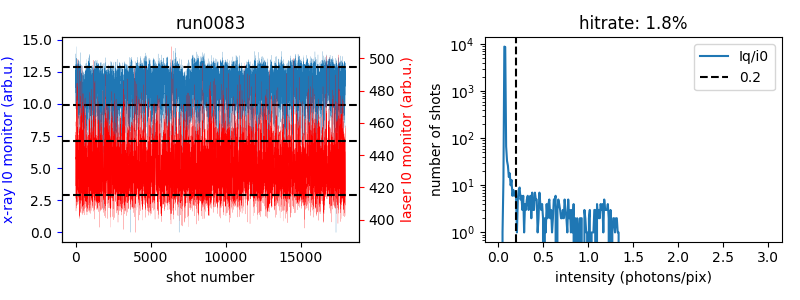

In [34]:
plt.figure(figsize=[8,3])

# i0 monitor
ax1 = plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
ax1.plot(i0[:int(nshots)],lw=.1)
ax1.set_ylabel('x-ray I0 monitor (arb.u.)',color='b')
ax1.set_xlabel('shot number')
ax1.tick_params('y',color='b')
m = i0[:int(nshots)].mean()
s = i0[:int(nshots)].std()
ax1.axhline(y=(m+1*s),c='black',ls='--')
ax1.axhline(y=(m-1*s),c='black',ls='--')

ax2 = ax1.twinx()
ax2.plot(np.arange(len(laser_i0))[laser_on.astype(np.bool)],laser_i0[laser_on.astype(np.bool)][:int(nshots)],lw=.1,color='r')
ax2.set_ylabel('laser I0 monitor (arb.u.)',color='r')
ax2.tick_params('y',color='r')
m = laser_i0[laser_on.astype(np.bool)][:int(nshots)].mean()
s = laser_i0[laser_on.astype(np.bool)][:int(nshots)].std()
ax2.axhline(y=(m+1*s),c='black',ls='--')
ax2.axhline(y=(m-1*s),c='black',ls='--')

# hit estimator
plt.subplot(1,2,2)
x,y = do_histogram(metric,0,3,.01)
plt.plot(x,y)
plt.axvline(x=iq_thr,c='black',ls='--')
plt.legend(['Iq/i0',iq_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.title('hitrate: %.1f%%'%(100*hit_rate))

plt.tight_layout()
plt.savefig('run%s_shot_statistics.png' % run)
plt.show()